In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the dataset path

import pathlib
data_dir = pathlib.Path(r"E:\Deep Learning\DL_Projects\Brain_tumor_classification\BrainTumor_Dataset")

In [3]:
data_dir

WindowsPath('E:/Deep Learning/DL_Projects/Brain_tumor_classification/BrainTumor_Dataset')

In [7]:
# Count the total number of images in a folwer directory

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3086

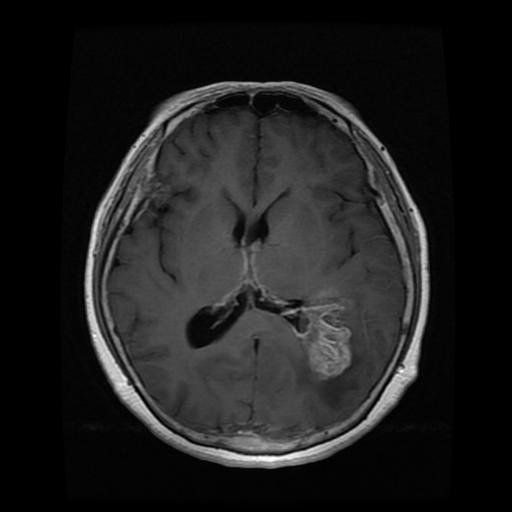

In [10]:
# Example of the braintumor dataset 

glioma_tumor = list(data_dir.glob('glioma_tumor/*'))
PIL.Image.open(str(glioma_tumor[1]))

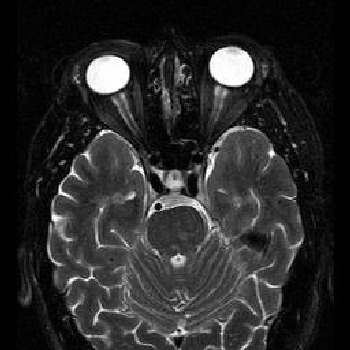

In [11]:
no_tumor = list(data_dir.glob('no_tumor/*'))
PIL.Image.open(str(no_tumor[1]))

In [27]:
# Setting the batch size and fixed image height and width
batch_size = 32
img_height = 180
img_width = 180

##### Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. 
##### It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

In [13]:
train_ds = image_dataset_from_directory(
data_dir,
validation_split=0.2,
seed = 123,
subset = "training",
image_size=(180,180),
batch_size=32)

Found 3086 files belonging to 4 classes.
Using 2469 files for training.


In [14]:
val_ds = image_dataset_from_directory(
data_dir,
validation_split=0.7,
seed = 123,
subset = "training",
image_size=(180,180),
batch_size=32)

Found 3086 files belonging to 4 classes.
Using 926 files for training.


#### You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [15]:
train_ds.class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [19]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [20]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Visualize the data

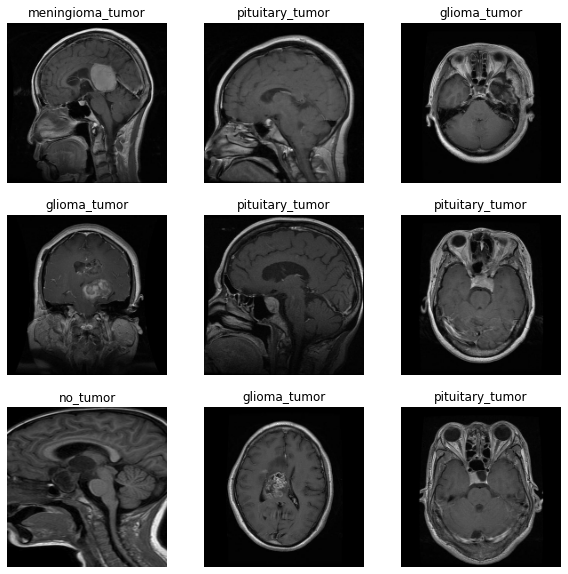

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### You will train a model using these datasets by passing them to Model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:
#### The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Standardize the data

#### The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

#### Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [23]:
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.8877004


#### Create the model

#### The Sequential model consists of three convolution blocks  with a max pooling layer in each of them.
#### here's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function

In [28]:
num_classes = len(class_names)

model = Sequential([
    # Input Layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Hidden layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    # Fully connect layer
  layers.Flatten(), # flatten layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # output layer
])

#### Compile a model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
78/78 [==============================] - 81s 1s/step - loss: 1.0004 - accuracy: 0.5597 - val_loss: 0.7160 - val_accuracy: 0.6901
Epoch 2/10
78/78 [==============================] - 75s 959ms/step - loss: 0.5901 - accuracy: 0.7521 - val_loss: 0.4296 - val_accuracy: 0.8402
Epoch 3/10
78/78 [==============================] - 75s 959ms/step - loss: 0.4254 - accuracy: 0.8319 - val_loss: 0.3550 - val_accuracy: 0.8510
Epoch 4/10
78/78 [==============================] - 73s 926ms/step - loss: 0.2717 - accuracy: 0.8979 - val_loss: 0.2013 - val_accuracy: 0.9276
Epoch 5/10
78/78 [==============================] - 73s 937ms/step - loss: 0.1634 - accuracy: 0.9465 - val_loss: 0.1043 - val_accuracy: 0.9654
Epoch 6/10
78/78 [==============================] - 73s 936ms/step - loss: 0.0979 - accuracy: 0.9668 - val_loss: 0.0588 - val_accuracy: 0.9806
Epoch 7/10
78/78 [==============================] - 77s 986ms/step - loss: 0.0601 - accuracy: 0.9834 - val_loss: 0.0469 - val_accuracy: 0.9870
Ep

### Visualize training results

#### Create plots of loss and accuracy on the training and validation sets:
#### The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

### Data augmentation

#### Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Predict on new data

In [38]:
pic='E:/images/braintumor.jpg'

img = tf.keras.utils.load_img(
    pic, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 222ms/step
This image most likely belongs to no_tumor with a 65.47 percent confidence.


#### Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

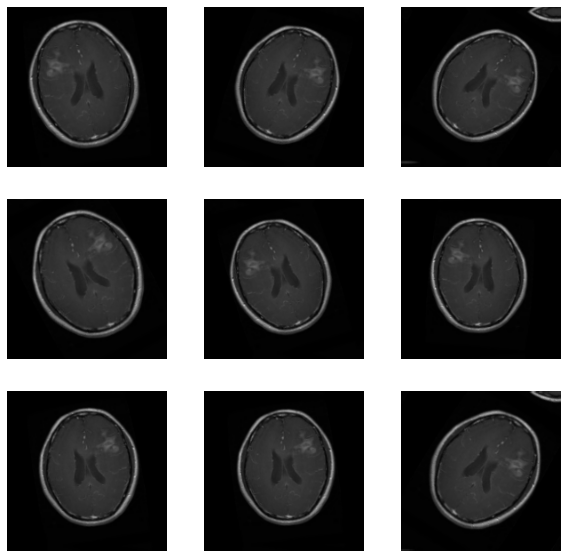

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

#### Another technique to reduce overfitting is to introduce dropout regularization to the network
#### When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc.

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile and train the model

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
78/78 [==============================] - 99s 1s/step - loss: 0.4430 - accuracy: 0.8153 - val_loss: 0.5548 - val_accuracy: 0.7819
Epoch 2/20
78/78 [==============================] - 101s 1s/step - loss: 0.4122 - accuracy: 0.8335 - val_loss: 0.3472 - val_accuracy: 0.8866
Epoch 3/20
78/78 [==============================] - 104s 1s/step - loss: 0.3957 - accuracy: 0.8530 - val_loss: 0.3754 - val_accuracy: 0.8639
Epoch 4/20
78/78 [==============================] - 105s 1s/step - loss: 0.3731 - accuracy: 0.8578 - val_loss: 0.3027 - val_accuracy: 0.9082
Epoch 5/20
78/78 [==============================] - 99s 1s/step - loss: 0.3507 - accuracy: 0.8647 - val_loss: 0.2740 - val_accuracy: 0.8931
Epoch 6/20
78/78 [==============================] - 94s 1s/step - loss: 0.3316 - accuracy: 0.8728 - val_loss: 0.3186 - val_accuracy: 0.8812
Epoch 7/20
78/78 [==============================] - 88s 1s/step - loss: 0.3029 - accuracy: 0.8874 - val_loss: 0.3941 - val_accuracy: 0.8521
Epoch 8/20
78/78 

In [48]:
pic='E:/images/gliomatumor.jpg'

img = tf.keras.utils.load_img(
    pic, target_size=(img_height, img_width)  
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to glioma_tumor with a 99.58 percent confidence.
